# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

In [2]:
import os
os.chdir('TDs-statistiques-descriptives')

In [3]:
ACARS = pd.read_excel("C:/Users/Yazid/Desktop/TD Stat/TD1/TDs-statistiques-descriptives/data/accars_b.xlsx")

#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

In [4]:
ACARS.isnull().any()

# Repartition 
(ACARS.isnull().sum() / len(ACARS) * 100).sort_values(ascending=False)


wbe                            78.717745
tsih                           70.536883
zwbp2                          70.011368
zwbp1                          70.011368
cycles                         65.534845
zhptac                         63.956157
zlptac                         63.930418
ztla                           60.828811
vbvpos                         58.420025
zt25                           56.534609
zt3                            56.534609
zps3                           55.414942
zvsv                           51.967997
zphsr                          28.950473
zphsf                          25.868171
cas                            25.567877
zwf36                          15.585251
zvb2f                          14.585702
zvb2r                          14.349757
zvb1f                          14.332597
zvb1r                          14.332597
ztoil                          14.070912
zpoil                          14.040883
pcn1k                           2.897836
sloatl          

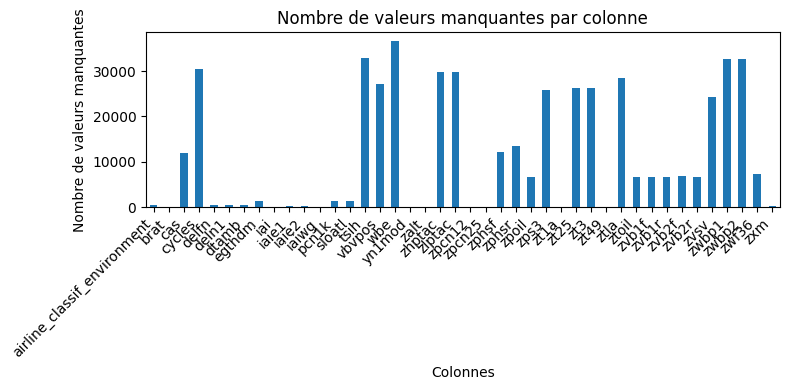

In [5]:
# Bar plot
val_nan = ACARS.isnull().sum()

# Filtrer pour afficher uniquement les colonnes qui ont des valeurs manquantes
val_nan = val_nan[val_nan > 0]

plt.figure(figsize=(8, 4))
val_nan.plot(kind='bar')
plt.title("Nombre de valeurs manquantes par colonne")
plt.ylabel("Nombre de valeurs manquantes")
plt.xlabel("Colonnes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [6]:
ACARS = ACARS.dropna(subset=['cycles', 'egthdm'])

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [7]:
ACARS['engine_type'].unique()

array([10,  5,  7], dtype=int64)

In [8]:
ACARS

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
104,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,5.0,23.8191,...,84.3,0.39,0.58,0.05,0.15,12.3,0.2,0.0,NaN,0.133
105,TAKEOFF,186,10,192,1,Neutral,0.0,93.0,6.0,25.4038,...,95.1,0.24,0.69,0.16,0.10,11.1,0.2,0.0,NaN,0.148
106,TAKEOFF,186,10,192,1,Neutral,0.0,92.0,7.0,22.7509,...,81.6,0.23,0.46,0.13,0.11,12.1,0.3,0.0,NaN,0.140
107,TAKEOFF,186,10,192,1,Neutral,0.0,87.0,8.0,22.1533,...,87.8,0.59,0.80,0.12,0.13,11.1,0.2,0.0,NaN,0.140
108,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,9.0,23.8673,...,79.3,0.43,0.47,0.13,0.17,12.5,0.3,0.0,NaN,0.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46575,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,19.0,13.0466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292
46576,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,44.0,12.7586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286
46577,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,67.0,14.8291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304
46599,TAKEOFF,328,7,154,2,Neutral,1.0,NaN,32.0,12.7096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [10]:
engine10 = ACARS[ACARS['engine_type'] == 10]

nb_avions = engine10.nunique().sum()
print(nb_avions)

vols_par_avion = engine10.groupby('aircraft_number').size() / 2
print("Nombre de vols par avion :")
print(vols_par_avion)


6763
Nombre de vols par avion :
aircraft_number
11      17.0
14      97.0
190    110.0
191      6.0
192    126.0
dtype: float64


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [11]:
avions_190 = ACARS[ACARS['aircraft_number'] == 190][['engine_number', 'cycles', 'egthdm']]

#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

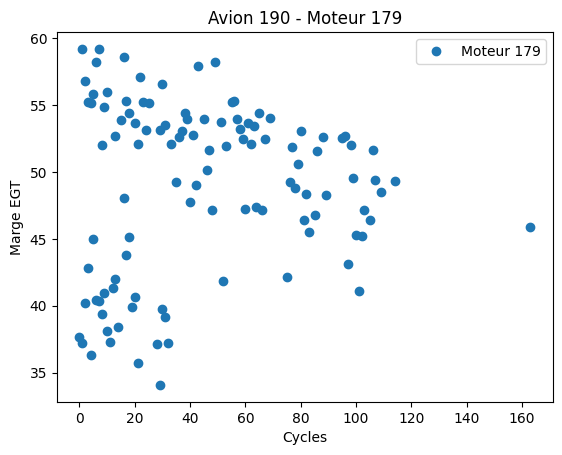

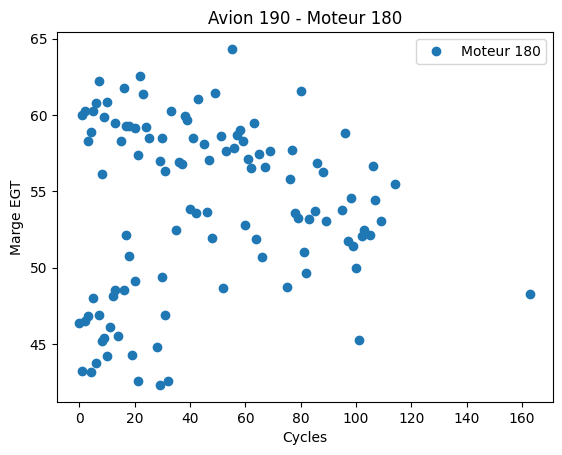

In [59]:
for moteur in avions_190['engine_number'].unique():
    df_m = avions_190[avions_190['engine_number'] == moteur]
    plt.figure()
    plt.plot(df_m['cycles'], df_m['egthdm'], 'o')
    plt.title(f"Avion 190 - Moteur {moteur}")
    plt.xlabel("Cycles")
    plt.ylabel("Marge EGT")
    plt.legend([f"Moteur {moteur}"])
    plt.show()


#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [31]:
moteur_179 = avions_190[avions_190["engine_number"] == 179]

cycles = moteur_179['cycles'].unique()
nan = (moteur_179['cycles'].max() - moteur_179['cycles'].min()) - len(cycles)
print(nan) 

72.0


#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [40]:
egt = moteur_179.groupby('cycles')['egthdm'].max()

egt.index = egt.index.astype(int)

egt = egt.reindex(range(egt.index.min(), egt.index.max() + 1))


#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

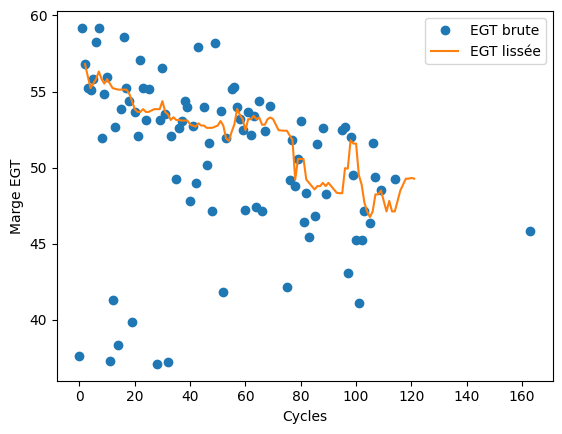

In [41]:
egt_lisse = egt.rolling(window=15, min_periods=3).median()

plt.figure()
plt.plot(egt.index, egt, 'o', label='EGT brute')
plt.plot(egt_lisse.index, egt_lisse, '-', label='EGT lissée')
plt.xlabel("Cycles")
plt.ylabel("Marge EGT")
plt.legend()
plt.show()


#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

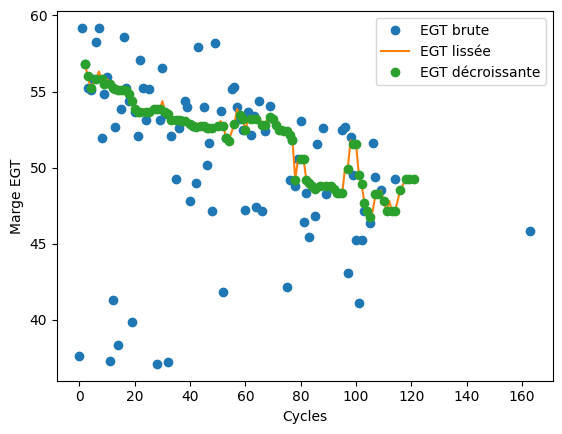

In [42]:
egt_decroissante = egt_lisse.copy()
for i in range(1, len(egt_decroissante)):
    if egt_decroissante.iloc[i] > egt_decroissante.iloc[i-1]:
        egt_decroissante.iloc[i] = None

plt.figure()
plt.plot(egt.index, egt, 'o', label='EGT brute')
plt.plot(egt_lisse.index, egt_lisse, '-', label='EGT lissée')
plt.plot(egt_decroissante.index, egt_decroissante, 'o', label='EGT décroissante')
plt.xlabel("Cycles")
plt.ylabel("Marge EGT")
plt.legend()
plt.show()


#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [43]:
from sklearn.linear_model import LinearRegression

In [45]:
# Supprimer les cycles où la marge EGT est NaN
egt_clean = egt.dropna()

X = egt_clean.index.values.reshape(-1, 1)
y = egt_clean.values

# Régression linéaire
lr = LinearRegression()
lr.fit(X, y)

print("Pente (coefficient) :", lr.coef_[0])
print("Ordonnée à l’origine (intercept) :", lr.intercept_)


Pente (coefficient) : -0.04017912754932413
Ordonnée à l’origine (intercept) : 52.804855185715134


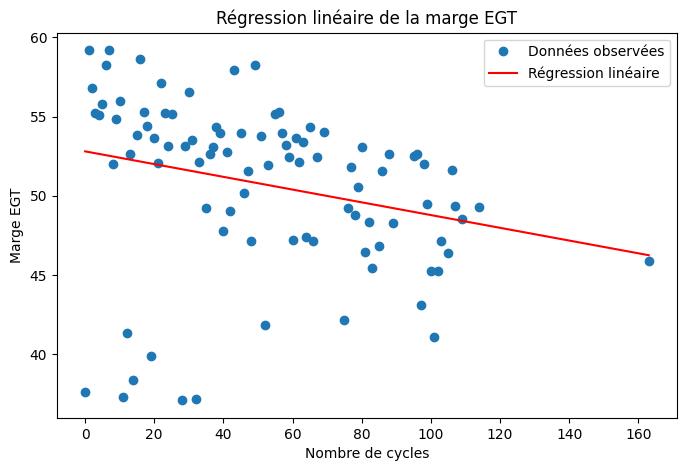

In [46]:
y_pred = lr.predict(X)

plt.figure(figsize=(8,5))
plt.plot(X, y, 'o', label='Données observées')
plt.plot(X, y_pred, 'r-', label='Régression linéaire')
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Régression linéaire de la marge EGT')
plt.legend()
plt.show()


### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

In [60]:
def regress_egt_margin(df_acars):
    
    regression_results = []
    
    # Grouper les données par numéro de moteur
    for engine_num, engine_group in df_acars.groupby('engine_number'):
        
        # S'assurer qu'il y a assez de données pour une régression
        if len(engine_group) < 3:
            continue
            
        # 1. Garder la marge EGT max par cycle
        egt = engine_group.groupby('cycles')['egthdm'].max()
        
        # S'assurer que l'index est un entier pour le réindexage
        egt.index = egt.index.astype(int)
        
        # 2. Ré-indexer pour combler les cycles manquants
        full_index = range(egt.index.min(), egt.index.max() + 1)
        egt_reindexed = egt.reindex(full_index)
        
        # 3. Lisser avec une médiane glissante
        egt_lisse = egt_reindexed.rolling(window=15, min_periods=3).median()
        
        # 4. Ne garder que les points descendants pour une estimation pessimiste
        egt_decroissante = egt_lisse.cummin().dropna()
        
        # S'assurer qu'il reste assez de points pour une régression linéaire
        if len(egt_decroissante) < 2:
            continue
            
        # Préparer les données pour Scikit-learn
        X = egt_decroissante.index.values.reshape(-1, 1)
        y = egt_decroissante.values
        
        # 5. Apprendre le modèle de régression linéaire
        lr = LinearRegression()
        model = lr.fit(X, y)
        
        # Stocker les résultats
        regression_results.append({
            'engine_number': engine_num,
            'pente': model.coef_[0],
            'intercept': model.intercept_
        })
        
    return pd.DataFrame(regression_results)



In [61]:
# Appliquer la fonction au DataFrame ACARS (celui après le nettoyage de la question 1.3)
df_regress_models = regress_egt_margin(ACARS)

# Pour l'analyse par type de moteur, fusionnons les résultats avec le type de chaque moteur
engine_types = ACARS[['engine_number', 'engine_type']].drop_duplicates()
df_regress_models = pd.merge(df_regress_models, engine_types, on='engine_number')

df_regress_models.head()

,engine_number,pente,intercept,engine_type
0,1,-0.116532,92.174649,5
1,2,-0.158127,107.357144,5
2,3,-0.054468,96.497194,5
3,4,-0.045646,95.739881,5
4,5,-0.136056,108.575594,5


### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

<Figure size 1000x600 with 0 Axes>

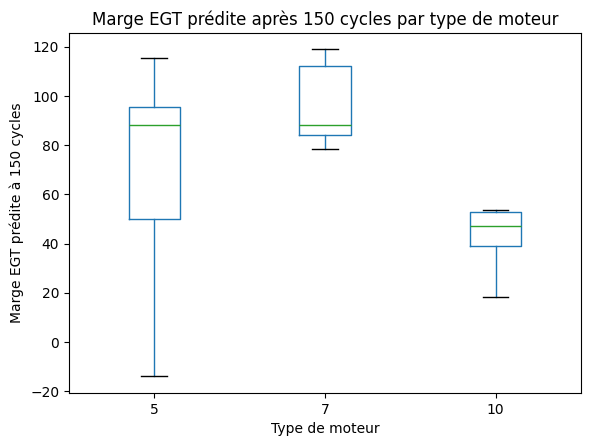

Moyenne de la marge EGT prédite au 150ème cycle par type de moteur :
engine_type
5     75.809509
7     95.666588
10    42.636241
Name: egt_pred_150, dtype: float64

Le type de moteur avec la plus grande marge moyenne après 150 cycles est le type : 7


In [62]:
# 1. Prédire la valeur de la marge EGT après 150 cycles
cycles_prediction = 150
df_regress_models['egt_pred_150'] = df_regress_models.apply(
    lambda row: row['intercept'] + row['pente'] * cycles_prediction,
    axis=1
)

# 2. Représenter ces valeurs sur un box plot
plt.figure(figsize=(10, 6))
df_regress_models.boxplot(column='egt_pred_150', by='engine_type', grid=False)
plt.title('Marge EGT prédite après 150 cycles par type de moteur')
plt.suptitle('') # Supprime le titre automatique généré par pandas
plt.xlabel('Type de moteur')
plt.ylabel('Marge EGT prédite à 150 cycles')
plt.show()

# 3. Calculer la moyenne par type de moteur
mean_egt_by_type = df_regress_models.groupby('engine_type')['egt_pred_150'].mean()
print("Moyenne de la marge EGT prédite au 150ème cycle par type de moteur :")
print(mean_egt_by_type)

print(f"\nLe type de moteur avec la plus grande marge moyenne après 150 cycles est le type : {mean_egt_by_type.idxmax()}")

# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

In [ ]:
import os
os.chdir('TDs-statistiques-descriptives')

In [ ]:
ACARS = pd.read_excel("C:/Users/Yazid/Desktop/TD Stat/TD1/TDs-statistiques-descriptives/data/accars_b.xlsx")

#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

In [ ]:
ACARS.isnull().any()

# Repartition 
(ACARS.isnull().sum() / len(ACARS) * 100).sort_values(ascending=False)


wbe                            78.717745
tsih                           70.536883
zwbp2                          70.011368
zwbp1                          70.011368
cycles                         65.534845
zhptac                         63.956157
zlptac                         63.930418
ztla                           60.828811
vbvpos                         58.420025
zt25                           56.534609
zt3                            56.534609
zps3                           55.414942
zvsv                           51.967997
zphsr                          28.950473
zphsf                          25.868171
cas                            25.567877
zwf36                          15.585251
zvb2f                          14.585702
zvb2r                          14.349757
zvb1f                          14.332597
zvb1r                          14.332597
ztoil                          14.070912
zpoil                          14.040883
pcn1k                           2.897836
sloatl          

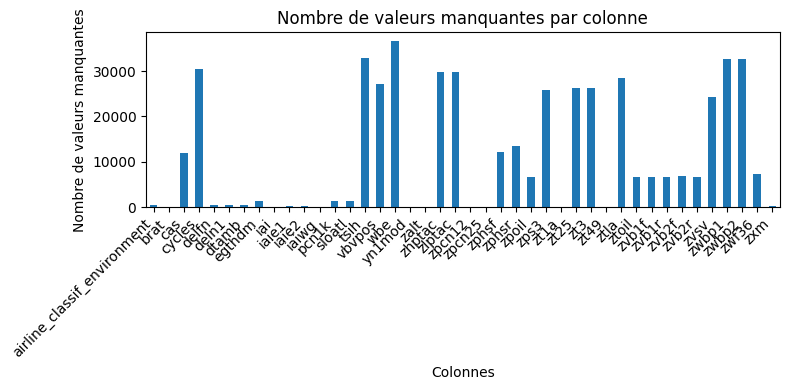

In [ ]:
# Bar plot
val_nan = ACARS.isnull().sum()

# Filtrer pour afficher uniquement les colonnes qui ont des valeurs manquantes
val_nan = val_nan[val_nan > 0]

plt.figure(figsize=(8, 4))
val_nan.plot(kind='bar')
plt.title("Nombre de valeurs manquantes par colonne")
plt.ylabel("Nombre de valeurs manquantes")
plt.xlabel("Colonnes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [ ]:
ACARS = ACARS.dropna(subset=['cycles', 'egthdm'])

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [ ]:
ACARS['engine_type'].unique()

array([10,  5,  7], dtype=int64)

In [ ]:
ACARS

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
104,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,5.0,23.8191,...,84.3,0.39,0.58,0.05,0.15,12.3,0.2,0.0,NaN,0.133
105,TAKEOFF,186,10,192,1,Neutral,0.0,93.0,6.0,25.4038,...,95.1,0.24,0.69,0.16,0.10,11.1,0.2,0.0,NaN,0.148
106,TAKEOFF,186,10,192,1,Neutral,0.0,92.0,7.0,22.7509,...,81.6,0.23,0.46,0.13,0.11,12.1,0.3,0.0,NaN,0.140
107,TAKEOFF,186,10,192,1,Neutral,0.0,87.0,8.0,22.1533,...,87.8,0.59,0.80,0.12,0.13,11.1,0.2,0.0,NaN,0.140
108,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,9.0,23.8673,...,79.3,0.43,0.47,0.13,0.17,12.5,0.3,0.0,NaN,0.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46575,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,19.0,13.0466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292
46576,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,44.0,12.7586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286
46577,TAKEOFF,289,7,153,2,Neutral,1.0,NaN,67.0,14.8291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304
46599,TAKEOFF,328,7,154,2,Neutral,1.0,NaN,32.0,12.7096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [ ]:
engine10 = ACARS[ACARS['engine_type'] == 10]

nb_avions = engine10.nunique().sum()
print(nb_avions)

vols_par_avion = engine10.groupby('aircraft_number').size() / 2
print("Nombre de vols par avion :")
print(vols_par_avion)


6763
Nombre de vols par avion :
aircraft_number
11      17.0
14      97.0
190    110.0
191      6.0
192    126.0
dtype: float64


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [ ]:
avions_190 = ACARS[ACARS['aircraft_number'] == 190][['engine_number', 'cycles', 'egthdm']]

#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

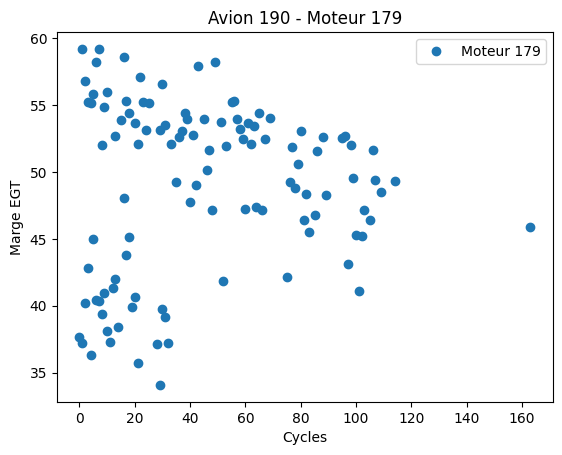

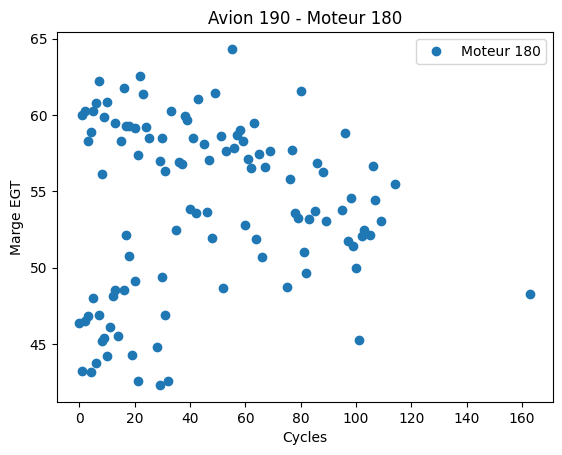

In [ ]:
for moteur in avions_190['engine_number'].unique():
    df_m = avions_190[avions_190['engine_number'] == moteur]
    plt.figure()
    plt.plot(df_m['cycles'], df_m['egthdm'], 'o')
    plt.title(f"Avion 190 - Moteur {moteur}")
    plt.xlabel("Cycles")
    plt.ylabel("Marge EGT")
    plt.legend([f"Moteur {moteur}"])
    plt.show()


#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [ ]:
moteur_179 = avions_190[avions_190["engine_number"] == 179]

cycles = moteur_179['cycles'].unique()
nan = (moteur_179['cycles'].max() - moteur_179['cycles'].min()) - len(cycles)
print(nan) 

72.0


#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [ ]:
egt = moteur_179.groupby('cycles')['egthdm'].max()

egt.index = egt.index.astype(int)

egt = egt.reindex(range(egt.index.min(), egt.index.max() + 1))


#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

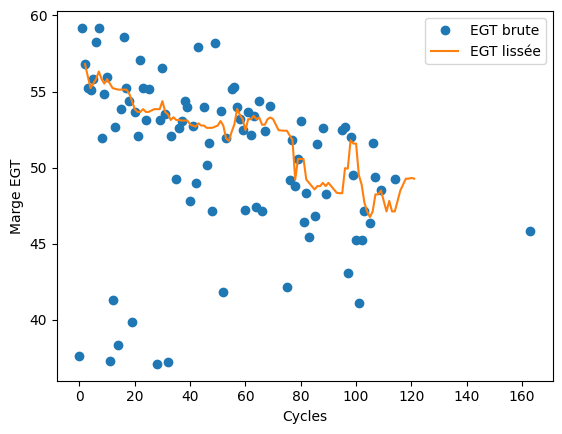

In [ ]:
egt_lisse = egt.rolling(window=15, min_periods=3).median()

plt.figure()
plt.plot(egt.index, egt, 'o', label='EGT brute')
plt.plot(egt_lisse.index, egt_lisse, '-', label='EGT lissée')
plt.xlabel("Cycles")
plt.ylabel("Marge EGT")
plt.legend()
plt.show()


#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

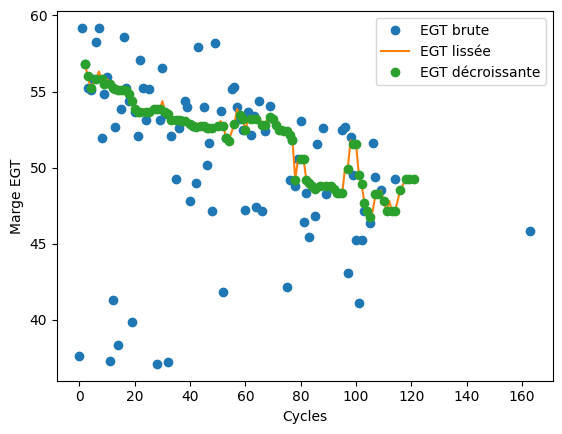

In [ ]:
egt_decroissante = egt_lisse.copy()
for i in range(1, len(egt_decroissante)):
    if egt_decroissante.iloc[i] > egt_decroissante.iloc[i-1]:
        egt_decroissante.iloc[i] = None

plt.figure()
plt.plot(egt.index, egt, 'o', label='EGT brute')
plt.plot(egt_lisse.index, egt_lisse, '-', label='EGT lissée')
plt.plot(egt_decroissante.index, egt_decroissante, 'o', label='EGT décroissante')
plt.xlabel("Cycles")
plt.ylabel("Marge EGT")
plt.legend()
plt.show()


#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Supprimer les cycles où la marge EGT est NaN
egt_clean = egt.dropna()

X = egt_clean.index.values.reshape(-1, 1)
y = egt_clean.values

# Régression linéaire
lr = LinearRegression()
lr.fit(X, y)

print("Pente (coefficient) :", lr.coef_[0])
print("Ordonnée à l’origine (intercept) :", lr.intercept_)


Pente (coefficient) : -0.04017912754932413
Ordonnée à l’origine (intercept) : 52.804855185715134


### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

In [63]:
def regress_egt_margin(df_acars):

    regression_results = []
    
    # Grouper les données par numéro de moteur
    for engine_num, engine_group in df_acars.groupby('engine_number'):
        
        # S'assurer qu'il y a assez de données pour une régression
        if len(engine_group) < 3:
            continue
            
        # 1. Garder la marge EGT max par cycle
        egt = engine_group.groupby('cycles')['egthdm'].max()
        
        # S'assurer que l'index est un entier pour le réindexage
        egt.index = egt.index.astype(int)
        
        # 2. Ré-indexer pour combler les cycles manquants
        full_index = range(egt.index.min(), egt.index.max() + 1)
        egt_reindexed = egt.reindex(full_index)
        
        # 3. Lisser avec une médiane glissante
        egt_lisse = egt_reindexed.rolling(window=15, min_periods=3).median()
        
        # 4. Ne garder que les points descendants pour une estimation pessimiste
        egt_decroissante = egt_lisse.cummin().dropna()
        
        # S'assurer qu'il reste assez de points pour une régression linéaire
        if len(egt_decroissante) < 2:
            continue
            
        # Préparer les données pour Scikit-learn
        X = egt_decroissante.index.values.reshape(-1, 1)
        y = egt_decroissante.values
        
        # 5. Apprendre le modèle de régression linéaire
        lr = LinearRegression()
        model = lr.fit(X, y)
        
        # Stocker les résultats
        regression_results.append({
            'engine_number': engine_num,
            'pente': model.coef_[0],
            'intercept': model.intercept_
        })
        
    return pd.DataFrame(regression_results)

# Appliquer la fonction au DataFrame ACARS (celui après le nettoyage de la question 1.3)
df_regress_models = regress_egt_margin(ACARS)

# Pour l'analyse par type de moteur, fusionnons les résultats avec le type de chaque moteur
engine_types = ACARS[['engine_number', 'engine_type']].drop_duplicates()
df_regress_models = pd.merge(df_regress_models, engine_types, on='engine_number')

df_regress_models.head()

,engine_number,pente,intercept,engine_type
0,1,-0.116532,92.174649,5
1,2,-0.158127,107.357144,5
2,3,-0.054468,96.497194,5
3,4,-0.045646,95.739881,5
4,5,-0.136056,108.575594,5


### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

<Figure size 1000x600 with 0 Axes>

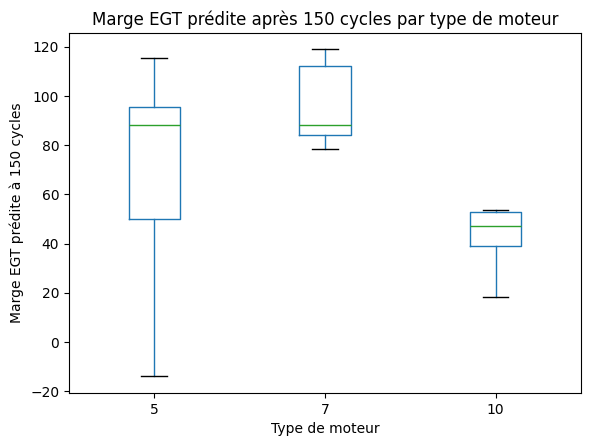

Moyenne de la marge EGT prédite au 150ème cycle par type de moteur :
engine_type
5     75.809509
7     95.666588
10    42.636241
Name: egt_pred_150, dtype: float64

Le type de moteur avec la plus grande marge moyenne après 150 cycles est le type : 7


In [64]:
# 1. Prédire la valeur de la marge EGT après 150 cycles
cycles_prediction = 150
df_regress_models['egt_pred_150'] = df_regress_models.apply(
    lambda row: row['intercept'] + row['pente'] * cycles_prediction,
    axis=1
)

# 2. Représenter ces valeurs sur un box plot
plt.figure(figsize=(10, 6))
df_regress_models.boxplot(column='egt_pred_150', by='engine_type', grid=False)
plt.title('Marge EGT prédite après 150 cycles par type de moteur')
plt.suptitle('') # Supprime le titre automatique généré par pandas
plt.xlabel('Type de moteur')
plt.ylabel('Marge EGT prédite à 150 cycles')
plt.show()

# 3. Calculer la moyenne par type de moteur
mean_egt_by_type = df_regress_models.groupby('engine_type')['egt_pred_150'].mean()
print("Moyenne de la marge EGT prédite au 150ème cycle par type de moteur :")
print(mean_egt_by_type)

print(f"\nLe type de moteur avec la plus grande marge moyenne après 150 cycles est le type : {mean_egt_by_type.idxmax()}")

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?

<Figure size 1000x600 with 0 Axes>

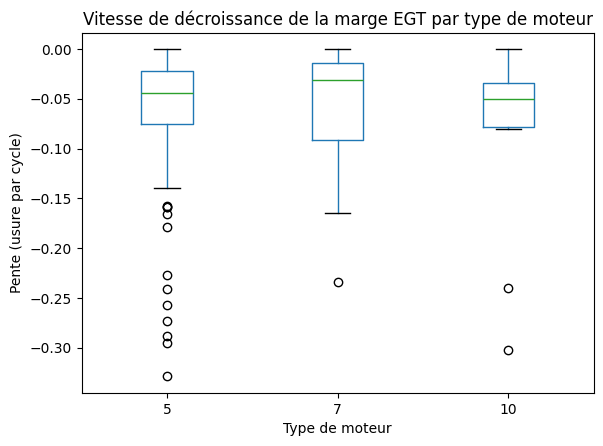

Vitesse de décroissance moyenne par type de moteur :
engine_type
5    -0.059912
7    -0.057895
10   -0.088075
Name: pente, dtype: float64

Le type de moteur avec la plus faible vitesse d'usure (pente la plus proche de 0) est le type : 7


In [65]:
# 2. Représenter les pentes sur un boxplot
plt.figure(figsize=(10, 6))
df_regress_models.boxplot(column='pente', by='engine_type', grid=False)
plt.title('Vitesse de décroissance de la marge EGT par type de moteur')
plt.suptitle('')
plt.xlabel('Type de moteur')
plt.ylabel('Pente (usure par cycle)')
plt.show()

# 3. Calculer la moyenne de la pente par type de moteur
mean_pente_by_type = df_regress_models.groupby('engine_type')['pente'].mean()
print("Vitesse de décroissance moyenne par type de moteur :")
print(mean_pente_by_type)

print(f"\nLe type de moteur avec la plus faible vitesse d'usure (pente la plus proche de 0) est le type : {mean_pente_by_type.idxmax()}")

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?

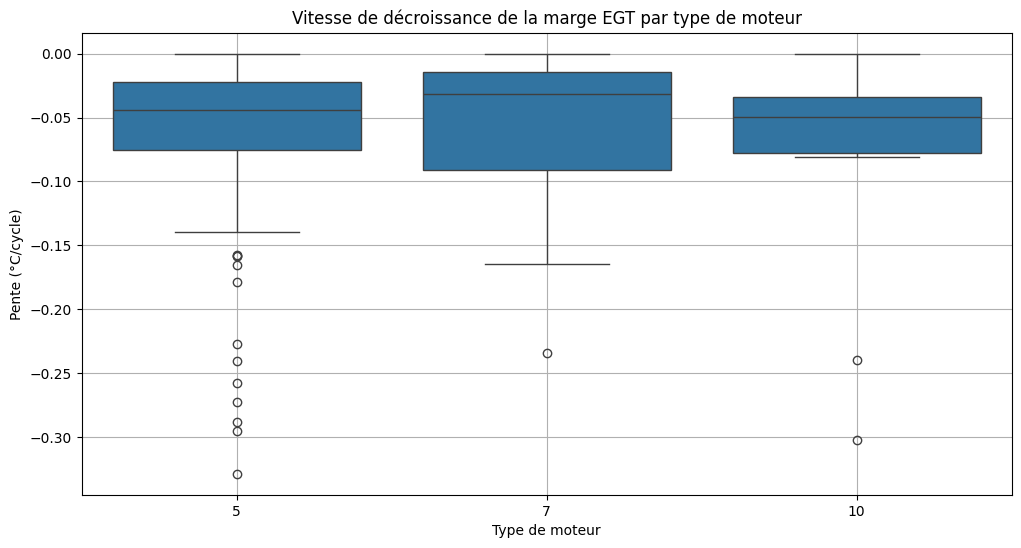

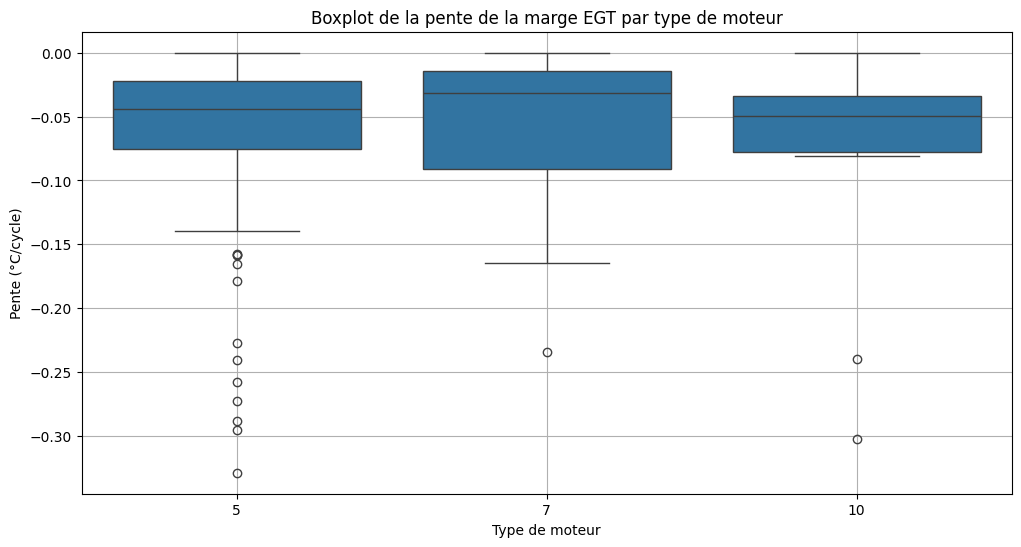